This note book configures a MIPI imager over I2C and displays the result on the display port OP and the enables capturing of image frames and video from the notebook for later analysis 

We start with loading in the overlay and all of the necessary packages

In [1]:
#from pynq.overlays.session_2 import session_2Overlay
from pynq import Overlay

In [4]:
#overlay = session_2Overlay('session_2.bit')
overlay = Overlay("/home/xilinx/pynq/overlays/session_2/session_2.bit")

Only run the cell below if you want to know what is included in the overlay

In [5]:
overlay?

In [6]:
from pynq.ps import Clocks
Clocks.fclk0_mhz

99.999

In [7]:
from pynq.lib.video import *
from pynq import pl
import cv2
import matplotlib.pyplot as plt
import scipy.ndimage
import matplotlib.image as mpimg

In [8]:
import smbus2
from smbus2 import SMBus, i2c_msg
from pynq import GPIO

The first thing to do is enable the MIPI camera power, this is controlled by PS GPIO on pin 37

In [9]:
output = GPIO(GPIO.get_gpio_pin(37), 'out')
output.write(1)

The next stage is to configure the camera over I2C we use the SMBus2 I2C_MSG package to be able to do this, first thing we want to do is detect the camera over the I2C if detected the camera ID of 0x78 will be displayed 

In [10]:
i2c_bus = smbus2.SMBus(4)
Sensor_addr = 0x3c

In [11]:
msg = i2c_msg.write(Sensor_addr, [0x31, 0x00])
i2c_bus.i2c_rdwr(msg)

In [12]:
msg = i2c_msg.read(Sensor_addr, 0x1)
i2c_bus.i2c_rdwr(msg)

In [13]:
data = list(msg)
print("Camera ID is = ",hex(data[0]))

Camera ID is =  0x78


The following configues the camera 

In [14]:
cfg = [[0x3008, 0x42],[0x3103, 0x03],[0x3017, 0x00],[0x3018, 0x00],[0x3034, 0x18], [0x3035, 0x11],[0x3036, 0x38],[0x3037, 0x11],[0x3108, 0x01],[0x303D, 0x10],[0x303B, 0x19],[0x3630, 0x2e],[0x3631, 0x0e],[0x3632, 0xe2],[0x3633, 0x23],[0x3621, 0xe0],[0x3704, 0xa0],[0x3703, 0x5a],
[0x3715, 0x78],[0x3717, 0x01],[0x370b, 0x60],[0x3705, 0x1a],[0x3905, 0x02],[0x3906, 0x10],[0x3901, 0x0a],[0x3731, 0x02],[0x3600, 0x37],[0x3601, 0x33],[0x302d, 0x60],[0x3620, 0x52],[0x371b, 0x20],
[0x471c, 0x50],[0x3a13, 0x43],[0x3a18, 0x00],[0x3a19, 0xf8],[0x3635, 0x13],[0x3636, 0x06],[0x3634, 0x44],[0x3622, 0x01],[0x3c01, 0x34],[0x3c04, 0x28],[0x3c05, 0x98],[0x3c06, 0x00],[0x3c07, 0x08],
[0x3c08, 0x00],[0x3c09, 0x1c],[0x3c0a, 0x9c],[0x3c0b, 0x40],[0x503d, 0x00],[0x3820, 0x46],[0x300e, 0x45],[0x4800, 0x14],[0x302e, 0x08],[0x4300, 0x6f],[0x501f, 0x01],[0x4713, 0x03],[0x4407, 0x04],
[0x440e, 0x00],[0x460b, 0x35],[0x460c, 0x20],[0x3824, 0x01],[0x5000, 0x07],[0x5001, 0x03]]

In [15]:
len(cfg)

63

In [16]:
for cmd in cfg:
    #print(hex(cmd[0]))
    #print(hex(cmd[1]))
    first = cmd[0].to_bytes(2,'big')
    #print(hex(first[0]), hex(first[1]), hex(cmd[1]))
    msg = i2c_msg.write(Sensor_addr, [first[0],first[1],cmd[1]])
    i2c_bus.i2c_rdwr(msg)

In [17]:
awb = [[0x518d ,0x00],[0x518f ,0x20],[0x518e ,0x00],[0x5190 ,0x20],[0x518b ,0x00],[0x518c ,0x00],[0x5187 ,0x10],[0x5188 ,0x10],
[0x5189 ,0x40],[0x518a ,0x40],[0x5186 ,0x10],[0x5181 ,0x58],[0x5184 ,0x25],[0x5182 ,0x11],[0x3406 ,0x00],[0x5183 ,0x80],[0x5191 ,0xff],
[0x5192 ,0x00],[0x5001 ,0x03]]

In [18]:
len(awb)

19

In [19]:
for cmd in awb:
    #print(hex(cmd[0]))
    #print(hex(cmd[1]))
    first = cmd[0].to_bytes(2,'big')
    #print(hex(first[0]), hex(first[1]), hex(cmd[1]))
    msg = i2c_msg.write(Sensor_addr, [first[0],first[1],cmd[1]])
    i2c_bus.i2c_rdwr(msg)

In [20]:
res_720p = [[0x3008, 0x42],	[0x3035, 0x21],[0x3036, 0x46],	[0x3037, 0x05],	[0x3108, 0x11],[0x3034, 0x1A],	[0x3800, (0 >> 8) & 0x0F],
[0x3801, 0 & 0xFF],[0x3802, (8 >> 8) & 0x07],[0x3803, 8 & 0xFF],[0x3804, (2619 >> 8) & 0x0F],[0x3805, 2619 & 0xFF],
[0x3806, (1947 >> 8) & 0x07],[0x3807, 1947 & 0xFF],[0x3810, (0 >> 8) & 0x0F],[0x3811, 0 & 0xFF],[0x3812, (0 >> 8) & 0x07],
[0x3813, 0 & 0xFF],[0x3808, (1280 >> 8) & 0x0F],[0x3809, 1280 & 0xFF],[0x380a, (720 >> 8) & 0x7F],[0x380b, 720 & 0xFF],
[0x380c, (1896 >> 8) & 0x1F],[0x380d, 1896 & 0xFF],[0x380e, (984 >> 8) & 0xFF],[0x380f, 984 & 0xFF],[0x3814, 0x31],
[0x3815, 0x31],[0x3821, 0x01],[0x4837, 36], [0x3618, 0x00], [0x3612, 0x59],[0x3708, 0x64],[0x3709, 0x52],[0x370c, 0x03],
[0x4300, 0x00],[0x501f, 0x03],[0x3008, 0x02]]

In [21]:
len(res_720p)

38

In [22]:
for cmd in res_720p:
    #print(hex(cmd[0]))
    #print(hex(cmd[1]))
    first = cmd[0].to_bytes(2,'big')
    #print(hex(first[0]), hex(first[1]), hex(cmd[1]))
    msg = i2c_msg.write(Sensor_addr, [first[0],first[1],cmd[1]])
    i2c_bus.i2c_rdwr(msg)

With the camera configured we need to then configure the demosaic, gamma and pixel packer IP as we need to use them

In [23]:
demo = overlay.v_demosaic_0
#gamma = overlay.v_gamma_lut_0

demo.write(0x10,1280)
demo.write(0x18,720)
demo.write(0x28,0x03)
demo.write(0x00,0x81)

#gamma.write(0x10,1280)
#gamma.write(0x18,720)
#gamma.write(0x20,0x00)
#gamma.write(0x00,0x00)

pixel_in = overlay.pixel_pack_0
pixel_in.bits_per_pixel = 24

Map in the MIPI interface so we can read status if requred 

In [24]:
mipi = overlay.mipi_csi2_rx_subsyst_0

In [25]:
op =mipi.read(0x60)
print("virtual channel 0 status =", hex(op))

virtual channel 0 status = 0xdfe30640


Congifure the VDMA to read an image from the PL into the PS

In [26]:
cam_vdma = overlay.axi_vdma_0
lines = 720
framemode = VideoMode(1280, lines, 24)
cam_vdma.readchannel.mode = framemode
cam_vdma.readchannel.start()

Check status of the VDMA channel this should report TRUE if running 

In [27]:
cam_vdma.readchannel.running 

True

Check the current configuration of the VDMA 

In [28]:
cam_vdma.readchannel.mode

VideoMode: width=1280 height=720 bpp=24

Grab an image from the VDMA and display it as an image, this is useful for grabbing stills from the sensor

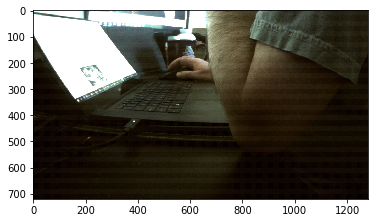

In [29]:
frame_camera = cam_vdma.readchannel.readframe()
frame_color=cv2.cvtColor(frame_camera,cv2.COLOR_BGR2RGB)
pixels = np.array(frame_color)
plt.imshow(pixels)
plt.show()

In [40]:
cv2.imwrite('img.jpg', frame_color)

True

In [76]:
framemode
vidOut=DisplayPort()
vidOut.configure(framemode,PIXEL_RGB)
frameOut=vidOut.newframe()
vidOut.writeframe(frameOut)

In [99]:
#while True:
fourcc = cv2.VideoWriter_fourcc(*'XVID')
video = cv2.VideoWriter('op.avi', fourcc, 25, (1280, 720))
ref_frame = cam_vdma.readchannel.readframe()
ref_gray  = cv2.cvtColor(ref_frame, cv2.COLOR_BGR2GRAY)
ref_blur  = cv2.GaussianBlur(ref_gray, (5,5), 0)
for i in range(0,500):
    frame_in = cam_vdma.readchannel.readframe()
    img_gray = cv2.cvtColor(frame_in, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(img_gray, (5,5), 0)
    difference = cv2.absdiff(ref_blur, blur)
    _, threshold = cv2.threshold(difference, 150, 255, cv2.THRESH_BINARY)[:]
    dilated = cv2.dilate(threshold, None, iterations=2)
    _, contours, heir = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for i in contours:
        if cv2.contourArea(i) < 15000:
            continue
        (x,y,w,h) = cv2.boundingRect(i)
        cv2.rectangle(frame_in, (x,y), (x+w,y+h),(0,0,255),2)
    frameOut[0:720,0:1280,:]=frame_in
    video.write(frame_in)
video.release()

In [74]:
vidOut.close()